In [38]:
# 1. Import library
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Probit
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
# 2. Baca dataset
df = pd.read_excel("Dataset TPT Jatim 2023.xlsx")

# Cek data awal
print(df)
print(df.describe())

             TPT       TPAK        IPM           UMK
count  38.000000  38.000000  38.000000  3.800000e+01
mean    4.662895  73.159211  73.680263  2.694768e+06
std     1.428828   3.767150   5.053755  7.891471e+05
min     1.710000  66.890000  64.130000  2.114335e+06
25%     4.082500  70.242500  70.215000  2.157664e+06
50%     4.665000  72.495000  72.790000  2.261496e+06
75%     5.600000  75.230000  76.760000  2.828888e+06
max     8.050000  81.640000  83.450000  4.525479e+06


In [40]:
df.describe()

,TPT,TPAK,IPM,UMK
count,38.000000,38.000000,38.000000,3.800000e+01
mean,4.662895,73.159211,73.680263,2.694768e+06
std,1.428828,3.767150,5.053755,7.891471e+05
min,1.710000,66.890000,64.130000,2.114335e+06
25%,4.082500,70.242500,70.215000,2.157664e+06
50%,4.665000,72.495000,72.790000,2.261496e+06
75%,5.600000,75.230000,76.760000,2.828888e+06
max,8.050000,81.640000,83.450000,4.525479e+06


In [41]:
df.dtypes

Kabupaten/Kota     object
TPT               float64
TPAK              float64
IPM               float64
UMK               float64
dtype: object

In [42]:
# 3. Buat variabel target (dummy TPT_high)
mean_TPT = df['TPT'].mean()
df['TPT_high'] = (df['TPT'] > mean_TPT).astype(int)

print("Rata-rata TPT Jatim 2023:", round(mean_TPT,2))
df[['Kabupaten/Kota','TPT','TPT_high']].head()

Rata-rata TPT Jatim 2023: 4.66


,Kabupaten/Kota,TPT,TPT_high
0,Pacitan,1.83,0
1,Ponorogo,4.66,0
2,Trenggalek,4.52,0
3,Tulungagung,5.65,1
4,Blitar,4.91,1


In [43]:
# 4. Transformasi variabel
df['log_UMK'] = np.log(df['UMK'])

In [44]:
# Definisikan variabel independen
X = df[['TPAK','IPM','log_UMK']]
X = sm.add_constant(X)   # tambah konstanta
y = df['TPT_high']

In [45]:
df['TPT_high'].value_counts()

TPT_high
0    19
1    19
Name: count, dtype: int64

In [48]:
counts = df['TPT_high'].value_counts().reset_index()
counts.columns = ['TPT_high', 'count']

fig = px.bar(
    counts, 
    x='TPT_high', 
    y='count',
    text='count',
    title='Distribusi TPT_high (0=Rendah, 1=Tinggi)',
    labels={'TPT_high':'TPT_high', 'count':'Jumlah'}
)
fig.update_traces(textposition='outside')
fig.show()

In [50]:
df.groupby('TPT_high').mean(numeric_only=True)

,TPT,TPAK,IPM,UMK,log_UMK
TPT_high,,,,,
0,3.625789,74.631053,71.278421,2.356937e+06,14.665964
1,5.700000,71.687368,76.082105,3.032600e+06,14.879607


In [51]:
# 5. Estimasi Model Probit (Maximum Likelihood Estimation)
model = Probit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.483999
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:               TPT_high   No. Observations:                   38
Model:                         Probit   Df Residuals:                       34
Method:                           MLE   Df Model:                            3
Date:                Fri, 26 Sep 2025   Pseudo R-squ.:                  0.3017
Time:                        20:22:39   Log-Likelihood:                -18.392
converged:                       True   LL-Null:                       -26.340
Covariance Type:            nonrobust   LLR p-value:                  0.001191
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -27.3190     20.006     -1.366      0.172     -66.530      11.892
TPAK          -0.1138      0.

In [52]:
# 6. Marginal Effects (untuk interpretasi)
mfx = model.get_margeff(at='overall', method='dydx')
print(mfx.summary())

       Probit Marginal Effects       
Dep. Variable:               TPT_high
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
TPAK          -0.0307      0.017     -1.835      0.067      -0.063       0.002
IPM            0.0297      0.013      2.258      0.024       0.004       0.056
log_UMK        0.5035      0.328      1.535      0.125      -0.139       1.146


In [53]:
# 7. Goodness-of-fit: Pseudo R² (McFadden)
llf = model.llf       # log-likelihood model
llnull = model.llnull # log-likelihood model kosong
pseudo_r2 = 1 - (llf/llnull)
print("Pseudo R-squared (McFadden):", round(pseudo_r2,3))

Pseudo R-squared (McFadden): 0.302


In [54]:
# 8. Validasi Model: Prediksi Probabilitas dan Confusion Matrix
df['pred_prob'] = model.predict(X)
df['pred_class'] = (df['pred_prob'] > 0.5).astype(int)

cm = confusion_matrix(y, df['pred_class'])
auc = roc_auc_score(y, df['pred_prob'])

print("Confusion Matrix:\n", cm)
print("AUC:", round(auc,3))

Confusion Matrix:
 [[14  5]
 [ 5 14]]
AUC: 0.837


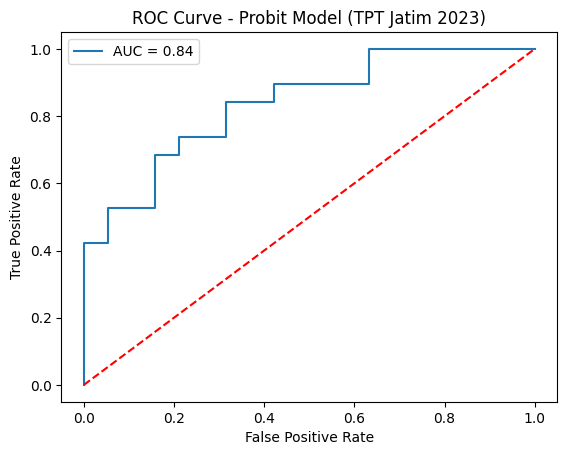

In [56]:
# 9. Visualisasi ROC Curve
fpr, tpr, thresholds = roc_curve(y, df['pred_prob'])
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1],'--',color='red')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Probit Model (TPT Jatim 2023)")
plt.legend()
plt.show()